In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
data = yf.download('USDINR=X', start="2019-01-01", end="2019-12-31")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,69.922501,69.925003,69.470001,69.922501,69.922501,0
2019-01-01,69.709999,69.730003,69.430000,69.709999,69.709999,0
2019-01-02,69.443001,70.233002,69.443001,69.709999,69.709999,0
2019-01-03,69.959999,70.510002,69.959999,69.959999,69.959999,0
2019-01-04,70.100502,70.130302,69.599998,70.300003,70.300003,0


In [12]:
short_MA = 10
long_MA = 30

# Create a table 'signals' with the `signal` column
signals = pd.DataFrame(index=data.index)
signals['signal'] = 0.0

# Compute short simple moving average 
signals['short_mavg'] = data['Close'].rolling(window=short_MA, min_periods=1, center=False).mean()

# Compute long simple moving average 
signals['long_mavg'] = data['Close'].rolling(window=long_MA, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_MA:] = np.where(signals['short_mavg'][short_MA:] 
                                            > signals['long_mavg'][short_MA:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals.tail(10))

            signal  short_mavg  long_mavg  positions
Date                                                
2019-12-17     0.0   71.098080  71.436490        0.0
2019-12-18     0.0   71.023580  71.447157        0.0
2019-12-19     0.0   70.974560  71.446820        0.0
2019-12-20     0.0   70.958330  71.441694        0.0
2019-12-23     0.0   70.932050  71.429944        0.0
2019-12-24     0.0   70.957101  71.417834        0.0
2019-12-25     0.0   71.002100  71.407167        0.0
2019-12-26     0.0   71.083170  71.387117        0.0
2019-12-27     0.0   71.157211  71.365267        0.0
2019-12-30     0.0   71.219611  71.352174        0.0


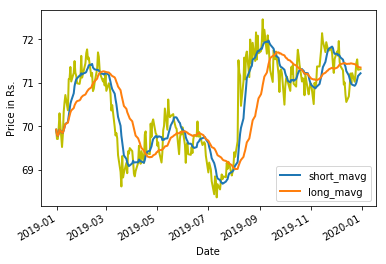

In [13]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in Rs.')

# Plot the closing price
data['Close'].plot(ax=ax1, color='y', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)
         
# Show the plot
plt.show()

In [15]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a table `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 1000 shares
positions['STPC'] = 10000*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(data['Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(data['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.tail())

            STPC  holdings           cash          total  returns
Date                                                             
2019-12-24   0.0       0.0  114785.919189  114785.919189      0.0
2019-12-25   0.0       0.0  114785.919189  114785.919189      0.0
2019-12-26   0.0       0.0  114785.919189  114785.919189      0.0
2019-12-27   0.0       0.0  114785.919189  114785.919189      0.0
2019-12-30   0.0       0.0  114785.919189  114785.919189      0.0


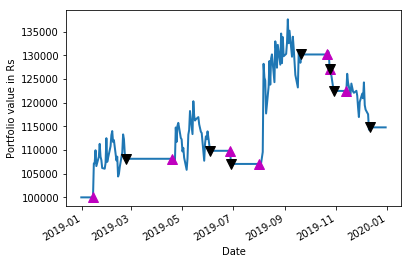

In [16]:
# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in Rs')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()